<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/Heatmap%2C_GSPD%2C_and_LSPD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cluster 1: Correlation Heatmap, Locally Shared Parameter Diagram, and Globally Shared Parameter Diagram Generator**

Upload data files for the WWTP unit processes in sequence.
Enter the full path to the next process file (e.g., Influent): /content/WAS Parameters.xlsx
What is the name of this process? (e.g., Influent): WAS
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/RAS with BioSolutions Line Atomizer Parameters.xlsx
What is the name of this process? (e.g., Influent): Oxygenated RAS
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/RAS Returned to Oxidation Ditch Parameters.xlsx
What is the name of this process? (e.g., Influent): RAS Returned to Oxidation Ditch
Do you want to add another process file? (yes/no): yes
Enter the full path to the next process file (e.g., Influent): /content/Oxidation Ditch Effluent Parameters.xlsx
What is the name of this process? (e.g., Influent): Oxidation Ditch Effluent
Do you want to add another process file? (y

DataFrame shape: (29, 12)
Bootstrapping correlation matrices...
Calculating and correcting p-values...
Generating heatmap...


DataFrame shape: (37, 12)
Bootstrapping correlation matrices...
Calculating and correcting p-values...
Generating heatmap...


Globally shared parameters across all node pairs: {'temperature', 'total atp', 'dissolved atp', 'ph', 'cellular atp'}
Generating Globally Shared Network Diagram...
Processing connection: WAS → Oxygenated RAS
Processing connection: Oxygenated RAS → RAS Returned to Oxidation Ditch
Processing connection: RAS Returned to Oxidation Ditch → Oxidation Ditch Effluent


<ipython-input-24-f345148f812b>:338: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



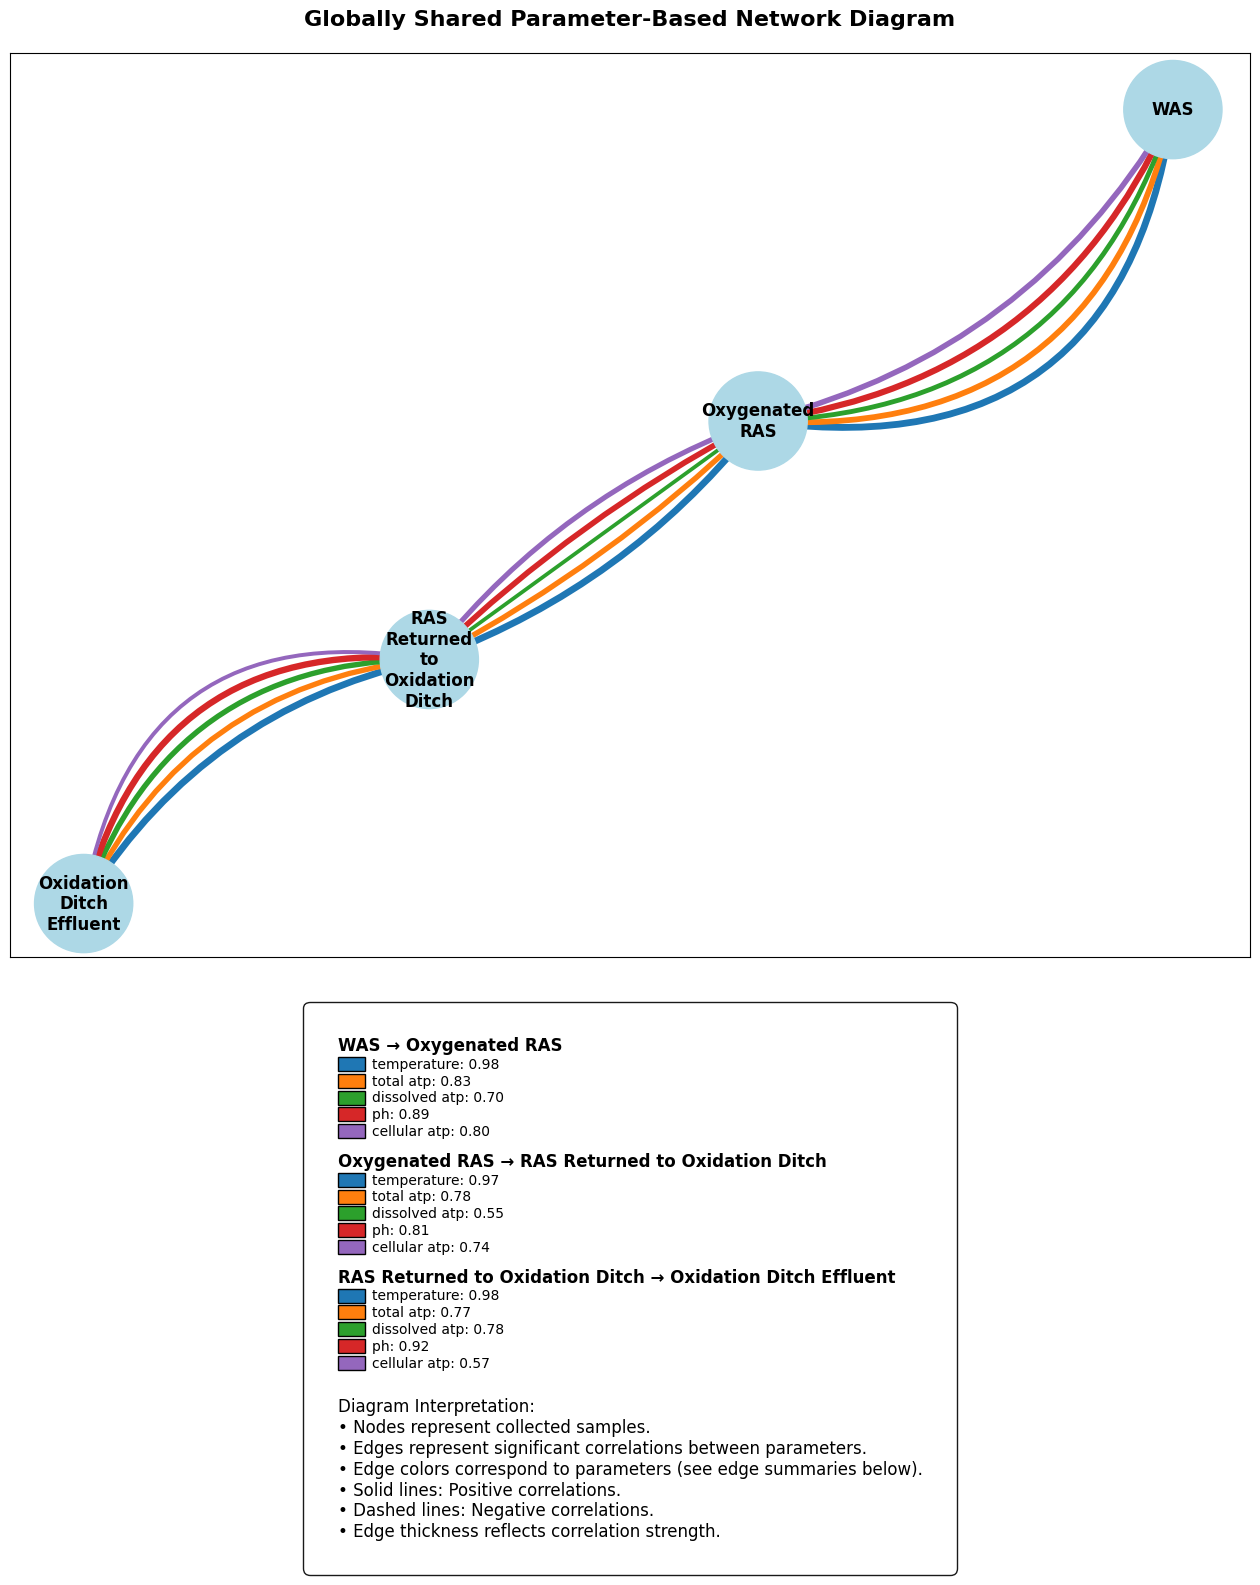

Generating Locally Shared Network Diagram...
Processing connection: WAS → Oxygenated RAS
Processing connection: Oxygenated RAS → RAS Returned to Oxidation Ditch
Processing connection: RAS Returned to Oxidation Ditch → Oxidation Ditch Effluent


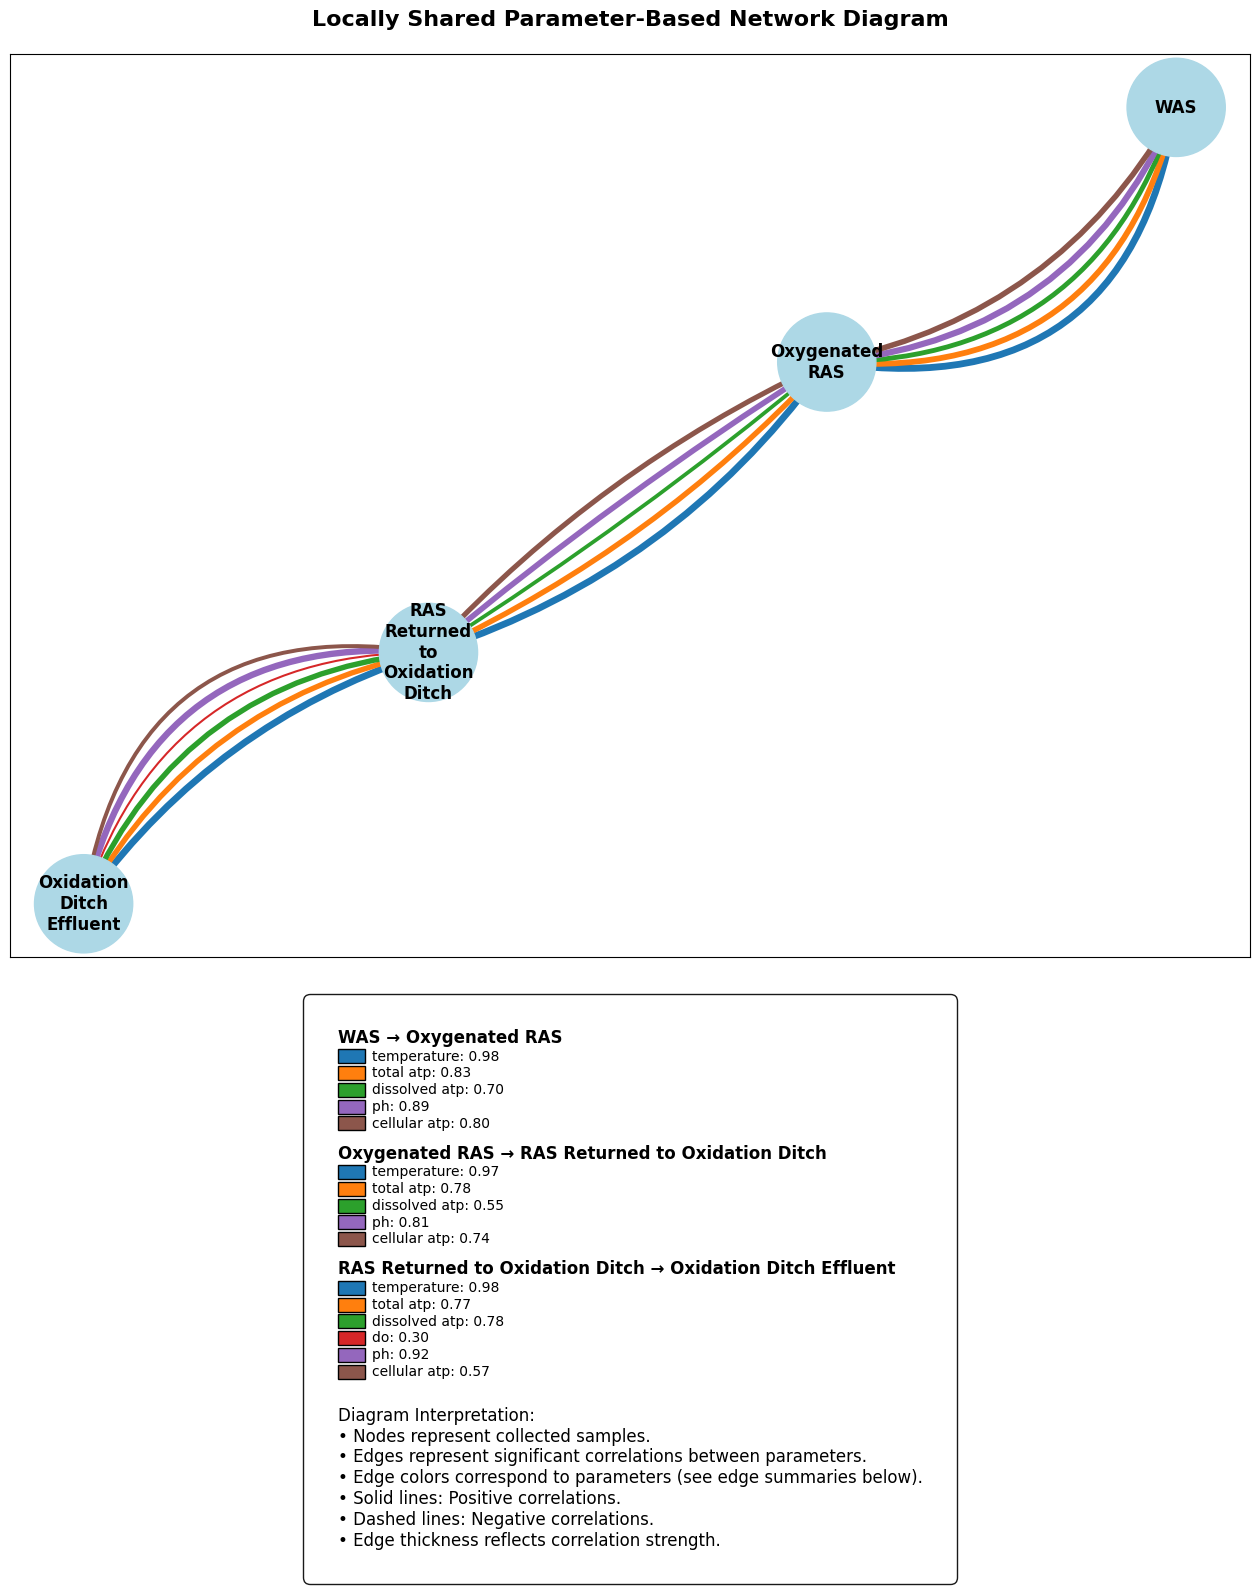

In [24]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
import textwrap
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import DrawingArea, TextArea, HPacker, VPacker, AnnotationBbox

def bootstrap_correlations(df, n_iterations=500, method='pearson'):
    correlations = []
    for i in range(n_iterations):
        df_resampled = resample(df)
        corr_matrix = df_resampled.corr(method=method)
        correlations.append(corr_matrix)
    median_corr = pd.concat(correlations).groupby(level=0).median()
    return median_corr

def calculate_p_values(df, method='pearson'):
    p_values = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col1, col2 in itertools.combinations(df.columns, 2):
        try:
            _, p_val = stats.pearsonr(df[col1], df[col2])
            p_values.at[col1, col2] = p_val
            p_values.at[col2, col1] = p_val
        except Exception:
            p_values.at[col1, col2] = 1
            p_values.at[col2, col1] = 1
    return p_values

def correct_p_values(p_values):
    _, corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')
    corrected_p = pd.DataFrame(corrected.reshape(p_values.shape), index=p_values.index, columns=p_values.columns)
    return corrected_p

def generate_heatmap(df, title, labels):
    """
    Generate a heatmap and return the filtered correlation matrix.
    """
    filtered_corr_matrix = validate_correlation_matrix(df)
    parameter_order = sorted(filtered_corr_matrix.index)
    filtered_corr_matrix = filtered_corr_matrix.loc[parameter_order, parameter_order]

    np.fill_diagonal(filtered_corr_matrix.values, 1)

    print("Generating heatmap...")
    fig = px.imshow(
        filtered_corr_matrix,
        text_auto=".2f",
        color_continuous_scale="RdBu",
        zmin=-1,
        zmax=1,
        labels={"x": labels[0], "y": labels[1], "color": "Correlation Coefficient"},
        title=title,
    )

    fig.update_layout(
        title=dict(font=dict(size=20), x=0.5),
        xaxis=dict(tickangle=45, title=None, tickfont=dict(size=12)),
        yaxis=dict(title=None, tickfont=dict(size=12)),
        autosize=False,
        width=1200,
        height=1000,
        margin=dict(l=100, r=100, t=100, b=100),
    )

    fig.show()
    return filtered_corr_matrix

# Helper function to identify shared parameters
def find_common_parameters(dataframes):
    """
    Identify parameters (columns) that are common across multiple DataFrames.
    """
    if not dataframes:
        return []

    # Start with all columns from the first DataFrame
    common_columns = set(dataframes[0].columns)

    # Intersect with columns from the remaining DataFrames
    for df in dataframes[1:]:
        common_columns &= set(df.columns)

    # Exclude the 'date' column
    common_columns.discard('date')

    return list(common_columns)

# Helper function to remove outliers using Z-score
def remove_outliers_zscore(df, threshold=3):
    """
    Remove outliers from a DataFrame using the Z-score method.
    """
    print("Applying Z-Score Method to filter outliers...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]

# Helper function to validate correlations
def validate_correlation_matrix(df, n_iterations=500, alpha=0.05):
    print("DataFrame shape:", df.shape)
    """
    Validate correlations using bootstrapping and p-value correction.
    Returns a filtered correlation matrix with only significant values.
    """
    print("Bootstrapping correlation matrices...")

    # Ensure all columns are numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna(axis=1, how='all')  # Drop columns that are entirely non-numeric or NaN

    pearson_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='pearson')
    spearman_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='spearman')
    kendall_corr = bootstrap_correlations(df, n_iterations=n_iterations, method='kendall')

    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3

    print("Calculating and correcting p-values...")
    p_values = calculate_p_values(df, method='pearson')
    corrected_p_values = correct_p_values(p_values)

    sig_mask = (corrected_p_values < alpha).astype(int)
    filtered_corr_matrix = avg_corr_matrix.where(sig_mask > 0).fillna(0)

    return filtered_corr_matrix

# Function to generate network diagram
def generate_network_diagram(labels, correlation_matrices, parameters, globally_shared=True):
    """
    Generate a parameter-based network diagram.
    If globally_shared is True, use globally shared parameters.
    Otherwise, use locally shared parameters for each edge.
    """
    import textwrap
    import numpy as np
    from matplotlib.colors import to_rgba
    import matplotlib.patches as mpatches

    G = nx.MultiGraph()  # Use MultiGraph to allow multiple edges between nodes
    diagram_type = "Globally Shared" if globally_shared else "Locally Shared"

    print(f"Generating {diagram_type} Network Diagram...")

    # Collect data for edge summary boxes
    edge_summaries = []

    for i in range(len(labels) - 1):
        print(f"Processing connection: {labels[i]} → {labels[i + 1]}")

        # Retrieve the filtered correlation matrix for this pair
        filtered_corr_matrix = correlation_matrices[i]

        # Track added edges to avoid duplicates
        added_edges = set()

        if globally_shared:
            parameters_to_use = parameters  # Use the set of globally shared parameters
        else:
            parameters_to_use = parameters[i]  # Use the list of parameters for this edge

        node1 = labels[i]
        node2 = labels[i + 1]

        edge_summary = {
            'nodes': (node1, node2),
            'parameters': []
        }

        for parameter in parameters_to_use:
            edge_key = (node1, node2, parameter)

            param1 = f"{parameter}_{node1}"
            param2 = f"{parameter}_{node2}"

            if param1 in filtered_corr_matrix.index and param2 in filtered_corr_matrix.columns:
                corr_value = filtered_corr_matrix.loc[param1, param2]

                if corr_value == 0 or edge_key in added_edges:
                    continue

                # Add nodes and edge
                G.add_node(node1, label=node1)
                G.add_node(node2, label=node2)

                G.add_edge(
                    node1,
                    node2,
                    parameter=parameter,
                    correlation=corr_value,
                    weight=abs(corr_value),
                    key=parameter  # Use the parameter as the key for multi-edges
                )
                added_edges.add(edge_key)

                # Add to edge summary
                edge_summary['parameters'].append((parameter, corr_value))

        if edge_summary['parameters']:
            edge_summaries.append(edge_summary)

    if G.number_of_nodes() == 0:
        print("No nodes to display in the network diagram.")
        return

    # Create a figure with GridSpec: 2 rows (network diagram and text boxes)
    fig = plt.figure(figsize=(16, 18))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)

    # Upper subplot for the network diagram
    ax_network = fig.add_subplot(gs[0, 0])

    # Adjust layout
    if globally_shared:
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, k=0.15, iterations=200, seed=42)  # Adjusted 'k' for closer nodes

    # Draw nodes
    node_colors = ["lightblue"] * len(G.nodes())
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color=node_colors, ax=ax_network)

    # Wrap node labels
    max_label_width = 10  # Adjust as needed
    formatted_labels = {}
    for node in G.nodes():
        label_text = G.nodes[node]['label'].replace("_", " ")
        wrapped_label = "\n".join(textwrap.wrap(label_text, width=max_label_width))
        formatted_labels[node] = wrapped_label

    # Draw labels with formatted labels
    nx.draw_networkx_labels(G, pos, labels=formatted_labels, font_size=12, font_weight="bold", ax=ax_network)

    # Assign unique colors to parameters
    unique_parameters = list(set(d['parameter'] for u, v, k, d in G.edges(keys=True, data=True)))
    num_params = len(unique_parameters)
    base_colors = plt.cm.tab10.colors  # You can choose other colormaps if you have more than 10 parameters
    if num_params > len(base_colors):
        base_colors = plt.cm.tab20.colors  # Use a colormap with more colors
    parameter_colors = dict(zip(unique_parameters, base_colors[:num_params]))

    # Function to adjust color intensity based on correlation strength
    def adjust_color_intensity(base_color, corr_value):
        rgba = to_rgba(base_color)
        intensity = 1.0  # Keep alpha at 1 for consistency
        adjusted_color = (rgba[0], rgba[1], rgba[2], intensity)
        return adjusted_color

    # Draw edges with curvature to avoid overlaps
    num_edges = len(G.edges(keys=True))
    curvature_values = np.linspace(-0.5, 0.5, num_edges)  # Adjusted for better curvature

    for idx, (u, v, key, d) in enumerate(G.edges(data=True, keys=True)):
        curvature = curvature_values[idx] if num_edges > 1 else 0.2
        corr_value = d['correlation']
        parameter = d['parameter']
        base_color = parameter_colors[parameter]
        edge_color = adjust_color_intensity(base_color, corr_value)

        # Choose line style based on correlation sign
        style = 'solid' if corr_value >= 0 else 'dashed'

        # Draw the edge
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=[(u, v, key)],
            connectionstyle=f"arc3,rad={curvature}",
            edge_color=[edge_color],
            width=d["weight"] * 5,
            style=style,
            ax=ax_network
        )

    # Set title for the network diagram
    ax_network.set_title(f"{diagram_type} Parameter-Based Network Diagram", fontsize=16, pad=20, weight="bold")

    # Create consolidated edge summary text box
    section_boxes = []

    for summary in edge_summaries:
        node1, node2 = summary['nodes']
        process_pair_title = f"{node1} → {node2}"
        title_area = TextArea(process_pair_title, textprops=dict(color='black', size=12, weight='bold'))

        # Create content boxes for parameters
        content_boxes = []
        for param, corr in summary['parameters']:
            color = parameter_colors[param]
            da = DrawingArea(20, 10, 0, 0)
            da.add_artist(mpatches.Rectangle((0, 0), 20, 10, fc=color, ec='black'))
            line_text = f"{param}: {corr:.2f}"
            ta = TextArea(line_text, textprops=dict(color='black', size=10))
            hbox = HPacker(children=[da, ta], align="center", pad=0, sep=5)
            content_boxes.append(hbox)
        # Pack the title and parameters vertically
        section_box = VPacker(children=[title_area] + content_boxes, align="left", pad=0, sep=2)
        section_boxes.append(section_box)

    # Pack all sections into one box with spacing
    all_sections_box = VPacker(children=section_boxes, align="left", pad=0, sep=10)

    # Diagram Interpretation
    interpretation_text = (
        "Diagram Interpretation:\n"
        "• Nodes represent collected samples.\n"
        "• Edges represent significant correlations between parameters.\n"
        "• Edge colors correspond to parameters (see edge summaries below).\n"
        "• Solid lines: Positive correlations.\n"
        "• Dashed lines: Negative correlations.\n"
        "• Edge thickness reflects correlation strength."
    )
    interpretation_area = TextArea(interpretation_text, textprops=dict(fontsize=12))

    # Combine edge summaries and interpretation
    combined_box = VPacker(children=[all_sections_box, interpretation_area], align="left", pad=20, sep=20)

    # Create the lower subplot for text boxes
    ax_text = fig.add_subplot(gs[1, 0])
    ax_text.axis("off")  # Hide the axes

    ab = AnnotationBbox(
        combined_box,
        (0.5, 0.5),  # Center of the subplot
        xycoords='axes fraction',
        box_alignment=(0.5, 0.5),
        bboxprops=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.9)
    )
    ax_text.add_artist(ab)

    plt.tight_layout()
    plt.show()

# Sequential file upload
def upload_files_sequentially():
    process_files = []
    process_labels = []

    while True:
        process_file = input("Enter the full path to the next process file (e.g., Influent): ")
        process_label = input(f"What is the name of this process? (e.g., Influent): ")

        process_files.append(process_file)
        process_labels.append(process_label)

        add_another = input("Do you want to add another process file? (yes/no): ").strip().lower()
        if add_another != 'yes':
            break

    return process_files, process_labels

# Read and align datasets with Z-score filtering
def read_file(file_path):
    """
    Read an Excel or CSV file into a DataFrame and normalize column names, with Z-score filtering.
    """
    try:
        print(f"Reading file: {file_path}")
        if file_path.endswith(".xlsx") or file_path.endswith(".xls"):
            df = pd.read_excel(file_path)
        elif file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported file format. Please use .xlsx, .xls, or .csv files.")

        df.columns = df.columns.str.lower().str.strip()
        if 'date' not in df.columns:
            raise KeyError(f"The file {file_path} does not contain a 'date' column.")
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=["date"])  # Drop rows with invalid dates
        df = remove_outliers_zscore(df)  # Apply Z-score filtering
        print(f"Finished processing file: {file_path}")
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        raise

# Main Function
if __name__ == "__main__":
    print("Upload data files for the WWTP unit processes in sequence.")
    process_files, process_labels = upload_files_sequentially()

    if len(process_files) < 2:
        print("Error: You need at least 2 files to generate diagrams.")
        exit()

    # Read data
    dataframes = [read_file(file) for file in process_files]

    # Common parameters
    common_params = find_common_parameters(dataframes)
    if not common_params:
        print("Error: No common parameters found.")
        exit()

    # Generate heatmaps and store correlation matrices
    correlation_matrices = []
    parameters_per_edge = []
    for i in range(len(dataframes) - 1):
        df1 = dataframes[i][['date'] + common_params]
        df2 = dataframes[i + 1][['date'] + common_params]
        merged_df = pd.merge(df1, df2, on="date", suffixes=(f"_{process_labels[i]}", f"_{process_labels[i + 1]}"))
        merged_df = merged_df.drop(columns=["date"], errors="ignore")

        # Handle invalid values
        merged_df = merged_df.replace([np.inf, -np.inf], np.nan)
        merged_df = merged_df.dropna()
        numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
        merged_df = merged_df[numeric_columns]

        filtered_corr_matrix = generate_heatmap(
            merged_df,
            f"Correlation Coefficient Heatmap: {process_labels[i]} vs {process_labels[i + 1]}",
            (process_labels[i], process_labels[i + 1]),
        )
        correlation_matrices.append(filtered_corr_matrix)

        # Identify parameters contributing to the correlation
        shared_params = []
        for param in common_params:
            infl_param = f"{param}_{process_labels[i]}"
            ode_param = f"{param}_{process_labels[i + 1]}"
            if infl_param in filtered_corr_matrix.index and ode_param in filtered_corr_matrix.columns:
                if filtered_corr_matrix.loc[infl_param, ode_param] != 0:
                    shared_params.append(param)
        parameters_per_edge.append(shared_params)

    # Identify globally shared parameters
    globally_shared_parameters = set(parameters_per_edge[0])
    for params in parameters_per_edge[1:]:
        globally_shared_parameters &= set(params)

    print(f"Globally shared parameters across all node pairs: {globally_shared_parameters}")
    if not globally_shared_parameters:
        print("Error: No globally shared parameters found.")
        exit()

    # Generate network diagrams
    generate_network_diagram(process_labels, correlation_matrices, globally_shared_parameters, globally_shared=True)
    generate_network_diagram(process_labels, correlation_matrices, parameters_per_edge, globally_shared=False)


# **Cluster 2: Correlation Bar Chart and Line Plot Generator**

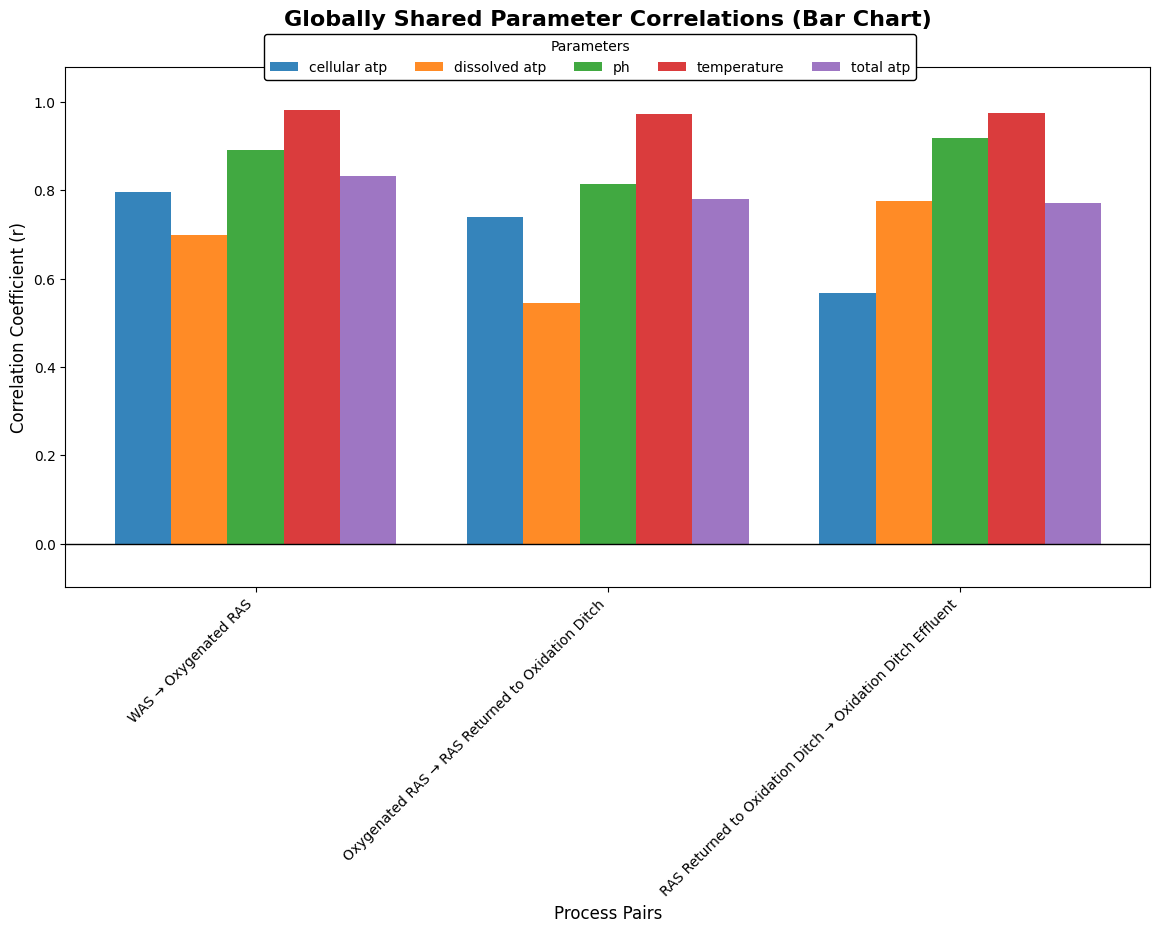

In [27]:
# Generate a bar chart summarizing correlations for globally shared parameters
import matplotlib.pyplot as plt
import numpy as np

def plot_gspd_bar_chart(process_labels, globally_shared_parameters, correlation_matrices):
    """
    Generate a bar chart summarizing correlations for globally shared parameters across process pairs.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Initialize data structure for correlations
    data = {param: [] for param in globally_shared_parameters}
    process_pairs = []

    # Collect correlation data for each process pair
    for i, matrix in enumerate(correlation_matrices):
        pair_label = f"{process_labels[i]} → {process_labels[i + 1]}"
        process_pairs.append(pair_label)

        for param in globally_shared_parameters:
            infl_param = f"{param}_{process_labels[i]}"
            ode_param = f"{param}_{process_labels[i + 1]}"

            if infl_param in matrix.index and ode_param in matrix.columns:
                corr_value = matrix.loc[infl_param, ode_param]
                data[param].append(corr_value)
            else:
                data[param].append(0)  # Fill missing correlations with 0

    # Compute y-limits for consistent axes
    all_correlations = [corr for correlations in data.values() for corr in correlations]
    ymin = min(all_correlations + [0])
    ymax = max(all_correlations + [0])
    y_range = ymax - ymin
    margin = y_range * 0.1  # Add 10% margin
    ymin -= margin
    ymax += margin

    # Plot bar chart
    num_process_pairs = len(process_pairs)
    num_parameters = len(globally_shared_parameters)
    total_bar_width = 0.8  # Total width for all bars at one x position
    bar_width = total_bar_width / num_parameters

    x = np.arange(num_process_pairs)  # Positions of the process pairs

    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot bars
    for i, (param, correlations) in enumerate(sorted(data.items())):
        offset = (i - (num_parameters - 1) / 2) * bar_width
        x_positions = x + offset
        ax.bar(x_positions, correlations, bar_width, label=param, alpha=0.9)

    ax.set_xlabel("Process Pairs", fontsize=12)
    ax.set_ylabel("Correlation Coefficient (r)", fontsize=12)

    # Adjust the title position
    ax.set_title("Globally Shared Parameter Correlations (Bar Chart)", fontsize=16, weight="bold", pad=30)

    # Adjust x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(process_pairs, rotation=45, ha="right")

    # Set y-limits
    ax.set_ylim(ymin, ymax)

    # Add horizontal line at r=0
    ax.axhline(y=0, color='black', linewidth=1)

    # Adjust the layout to make room for the legend and title
    fig.subplots_adjust(top=0.85, bottom=0.2)

    # Position the legend just below the title and add a box around it
    legend = fig.legend(
        title="Parameters",
        loc='upper center',
        bbox_to_anchor=(0.5, 0.90),
        ncol=len(globally_shared_parameters),
        frameon=True  # Add a box around the legend
    )

    # Adjust the legend's transparency and outline color
    legend.get_frame().set_facecolor('white')  # Set legend background color to white
    legend.get_frame().set_alpha(1.0)  # Make legend opaque
    legend.get_frame().set_edgecolor('black')  # Set legend outline color to black

    plt.show()


# Generate the bar chart
plot_gspd_bar_chart(process_labels, globally_shared_parameters, correlation_matrices)


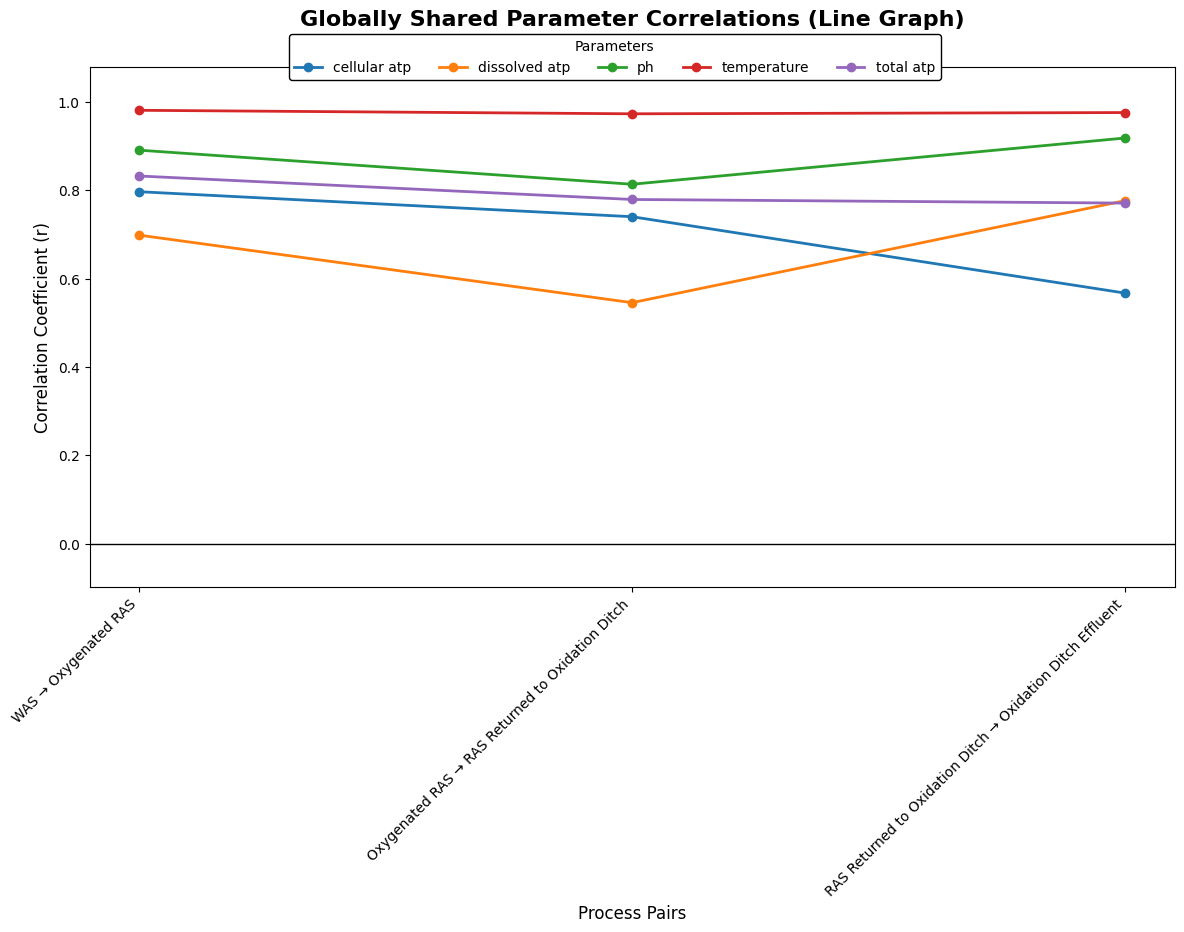

In [28]:
def plot_gspd_line_graph(process_labels, globally_shared_parameters, correlation_matrices):
    """
    Generate a line graph summarizing correlations for globally shared parameters across process pairs.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Initialize data structure for correlations
    data = {param: [] for param in globally_shared_parameters}
    process_pairs = []

    # Collect correlation data for each process pair
    for i, matrix in enumerate(correlation_matrices):
        pair_label = f"{process_labels[i]} → {process_labels[i + 1]}"
        process_pairs.append(pair_label)

        for param in globally_shared_parameters:
            infl_param = f"{param}_{process_labels[i]}"
            ode_param = f"{param}_{process_labels[i + 1]}"

            if infl_param in matrix.index and ode_param in matrix.columns:
                corr_value = matrix.loc[infl_param, ode_param]
                data[param].append(corr_value)
            else:
                data[param].append(0)  # Fill missing correlations with 0

    # Use the same y-limits as the bar chart
    all_correlations = [corr for correlations in data.values() for corr in correlations]
    ymin = min(all_correlations + [0])
    ymax = max(all_correlations + [0])
    y_range = ymax - ymin
    margin = y_range * 0.1  # Add 10% margin
    ymin -= margin
    ymax += margin

    x = np.arange(len(process_pairs))  # Positions of the process pairs

    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot lines
    for param, correlations in sorted(data.items()):
        ax.plot(x, correlations, marker='o', linewidth=2, label=param)

    ax.set_xlabel("Process Pairs", fontsize=12)
    ax.set_ylabel("Correlation Coefficient (r)", fontsize=12)

    # Adjust the title position
    ax.set_title("Globally Shared Parameter Correlations (Line Graph)", fontsize=16, weight="bold", pad=30)

    # Adjust x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(process_pairs, rotation=45, ha="right")

    # Set y-limits
    ax.set_ylim(ymin, ymax)

    # Add horizontal line at r=0
    ax.axhline(y=0, color='black', linewidth=1)

    # Adjust the layout to make room for the legend and title
    fig.subplots_adjust(top=0.85, bottom=0.2)

    # Position the legend just below the title and add a box around it
    legend = fig.legend(
        title="Parameters",
        loc='upper center',
        bbox_to_anchor=(0.5, 0.90),
        ncol=len(globally_shared_parameters),
        frameon=True  # Add a box around the legend
    )

    # Adjust the legend's transparency and outline color
    legend.get_frame().set_facecolor('white')  # Set legend background color to white
    legend.get_frame().set_alpha(1.0)  # Make legend opaque
    legend.get_frame().set_edgecolor('black')  # Set legend outline color to black

    plt.show()


# Generate the line graph
plot_gspd_line_graph(process_labels, globally_shared_parameters, correlation_matrices)

# **Cluster 3: Targeted-Parameter Diagram (v2)**

Available Processes:
1: WAS
2: Oxygenated RAS
3: RAS Returned to Oxidation Ditch
4: Oxidation Ditch Effluent
Select a process by entering its number: 2

Available Parameters in Oxygenated RAS:
1: phosphorus
2: ammonia
3: cellular atp
4: cod
5: dissolved atp
6: do
7: nitrate
8: nitrite
9: ph
10: tss
11: temperature
12: tkn
13: total atp
14: total nitrogen
Select a parameter by entering its number: 6

Enter the significance level alpha (default 0.05): 0.1

Generating network diagram for do in Oxygenated RAS with alpha=0.1...
Applying Z-Score Method to filter outliers...
Bootstrapping correlations...
Calculating and correcting p-values...


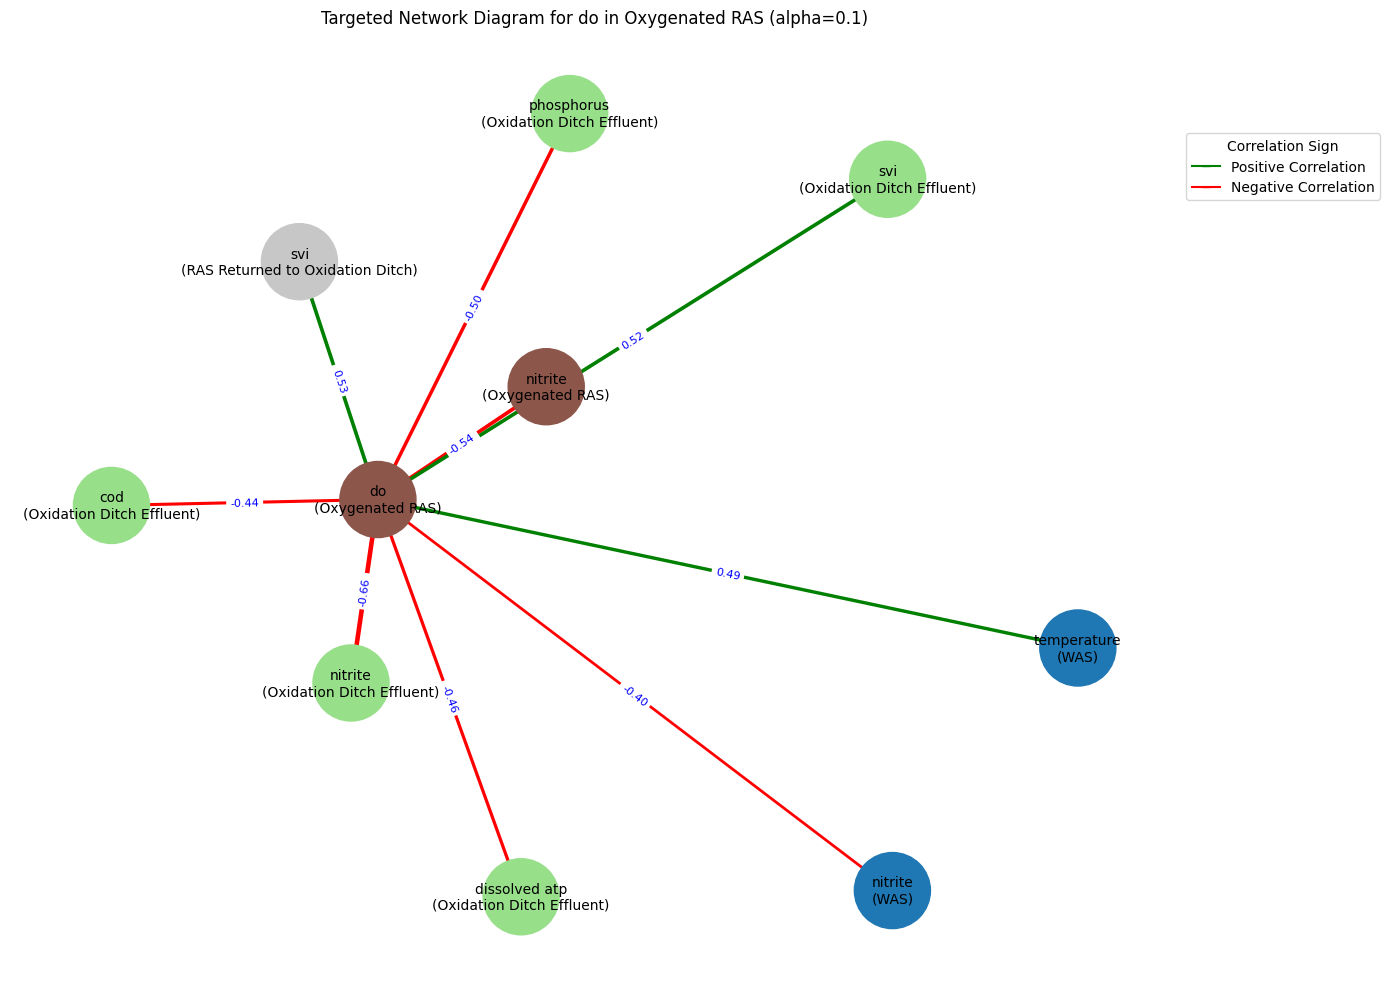

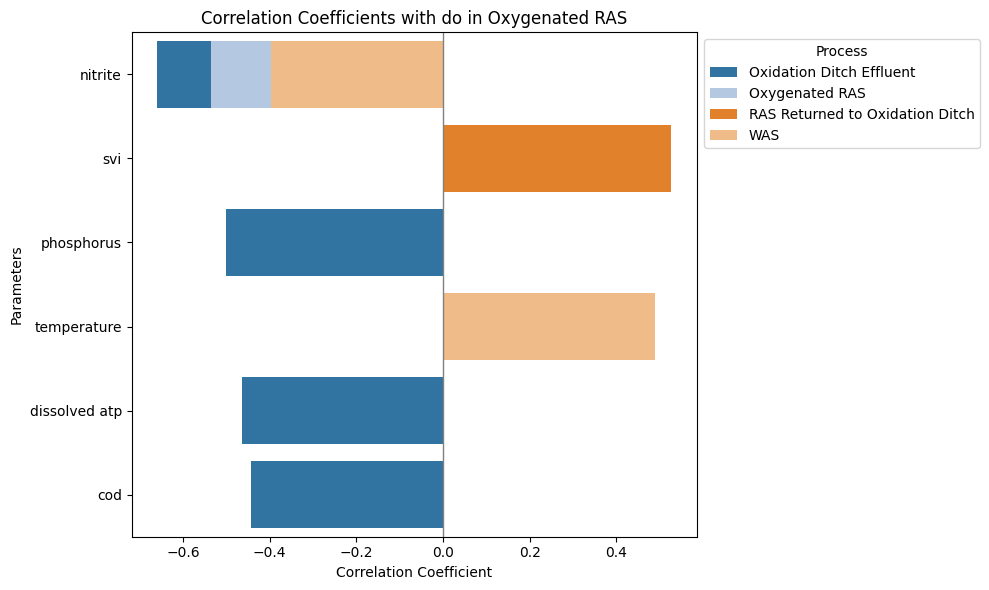

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import networkx as nx

# Ensure that the helper functions are defined: bootstrap_correlations and remove_outliers_zscore

def bootstrap_correlations(df, n_iterations=500, method='pearson'):
    correlations = []
    for i in range(n_iterations):
        df_resampled = resample(df)
        corr_matrix = df_resampled.corr(method=method)
        correlations.append(corr_matrix)
    median_corr = pd.concat(correlations).groupby(level=0).median()
    return median_corr

def remove_outliers_zscore(df, threshold=3):
    """
    Remove outliers from a DataFrame using the Z-score method.
    """
    print("Applying Z-Score Method to filter outliers...")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
    mask = (z_scores < threshold).all(axis=1)
    return df[mask]

# Updated standalone function with bootstrapping and Z-score outlier removal
def generate_targeted_network_diagram_standalone(process_labels, dataframes, n_iterations=500, alpha=0.05):
    """
    Generate a targeted network diagram centered around a selected parameter from a selected process.
    Allows independent adjustment of the significance level (alpha).
    """
    # Display available processes
    print("Available Processes:")
    for idx, label in enumerate(process_labels):
        print(f"{idx + 1}: {label}")

    # User selects a process
    process_choice = int(input("Select a process by entering its number: ")) - 1
    selected_process_label = process_labels[process_choice]
    selected_dataframe = dataframes[process_choice]

    # Display available parameters in the selected process
    available_parameters = selected_dataframe.columns.drop('date', errors='ignore')
    print(f"\nAvailable Parameters in {selected_process_label}:")
    for idx, param in enumerate(available_parameters):
        print(f"{idx + 1}: {param}")

    # User selects a parameter
    param_choice = int(input("Select a parameter by entering its number: ")) - 1
    selected_parameter = available_parameters[param_choice]

    # User sets the significance level (alpha)
    alpha_input = input(f"\nEnter the significance level alpha (default {alpha}): ").strip()
    if alpha_input:
        alpha = float(alpha_input)

    print(f"\nGenerating network diagram for {selected_parameter} in {selected_process_label} with alpha={alpha}...")

    # Prepare data for correlations
    combined_df = selected_dataframe[['date', selected_parameter]].copy()
    combined_df.columns = ['date', f"{selected_parameter}_{selected_process_label}"]

    # Include parameters from the same process
    df_same_process = selected_dataframe.drop(columns=[selected_parameter], errors='ignore')
    df_same_process.columns = [f"{col}_{selected_process_label}" if col != 'date' else 'date' for col in df_same_process.columns]

    # Merge on 'date'
    combined_df = pd.merge(combined_df, df_same_process, on='date', how='inner')

    # Include parameters from other processes
    for idx, df in enumerate(dataframes):
        if idx != process_choice:
            process_label = process_labels[idx]
            df_temp = df.copy()
            df_temp.columns = [f"{col}_{process_label}" if col != 'date' else 'date' for col in df_temp.columns]
            combined_df = pd.merge(combined_df, df_temp, on='date', how='inner')

    # Handle invalid values
    combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
    combined_df = combined_df.dropna()
    numeric_columns = combined_df.select_dtypes(include=[np.number]).columns
    combined_df = combined_df[numeric_columns]

    # Apply Z-score outlier removal
    combined_df = remove_outliers_zscore(combined_df, threshold=3)

    # Bootstrapping Correlations
    print("Bootstrapping correlations...")
    # Perform bootstrapping for Pearson, Spearman, and Kendall correlations
    pearson_corr = bootstrap_correlations(combined_df, n_iterations=n_iterations, method='pearson')
    spearman_corr = bootstrap_correlations(combined_df, n_iterations=n_iterations, method='spearman')
    kendall_corr = bootstrap_correlations(combined_df, n_iterations=n_iterations, method='kendall')

    # Average the correlation matrices
    avg_corr_matrix = (pearson_corr + spearman_corr + kendall_corr) / 3

    target_param_full = f"{selected_parameter}_{selected_process_label}"
    if target_param_full not in avg_corr_matrix.columns:
        print(f"Error: The selected parameter '{selected_parameter}' is not available in the data.")
        return
    target_correlations = avg_corr_matrix[target_param_full].drop(target_param_full)

    # Calculate p-values
    print("Calculating and correcting p-values...")
    p_values = pd.Series(dtype=float)
    for col in target_correlations.index:
        if np.all(combined_df[target_param_full] == combined_df[col]):
            # Perfect correlation, p-value is zero
            p_values[col] = 0.0
            continue
        try:
            _, p_val = stats.pearsonr(combined_df[target_param_full], combined_df[col])
            p_values[col] = p_val
        except Exception as e:
            print(f"Error calculating p-value between {target_param_full} and {col}: {e}")
            p_values[col] = 1.0  # Assign non-significant p-value
            continue

    # Apply multiple testing correction
    _, corrected_p_values, _, _ = multipletests(p_values.values, alpha=alpha, method='fdr_bh')
    significance_mask = corrected_p_values < alpha
    significant_correlations = target_correlations[significance_mask]
    significant_p_values = corrected_p_values[significance_mask]

    # Check if any significant correlations are found
    if significant_correlations.empty:
        print("No significant correlations found with the selected alpha level.")
        return

    # Prepare data for bar chart
    corr_data = pd.DataFrame({
        'Parameter': significant_correlations.index,
        'Correlation': significant_correlations.values,
        'P-value': significant_p_values
    })
    corr_data['Process'] = corr_data['Parameter'].apply(lambda x: x.rsplit('_', 1)[1])
    corr_data['Parameter Name'] = corr_data['Parameter'].apply(lambda x: x.rsplit('_', 1)[0])
    corr_data = corr_data.sort_values('Correlation', key=abs, ascending=False)

    # Separate internal and external correlations
    internal_corr = corr_data[corr_data['Process'] == selected_process_label]
    external_corr = corr_data[corr_data['Process'] != selected_process_label]

    # Generate the network diagram
    G = nx.Graph()
    G.add_node(target_param_full, label=selected_parameter, process=selected_process_label)

    # Add internal correlations
    for idx, row in internal_corr.iterrows():
        G.add_node(row['Parameter'], label=row['Parameter Name'], process=row['Process'])
        G.add_edge(
            target_param_full,
            row['Parameter'],
            correlation=row['Correlation'],
            weight=abs(row['Correlation'])
        )

    # Add external correlations
    for idx, row in external_corr.iterrows():
        G.add_node(row['Parameter'], label=row['Parameter Name'], process=row['Process'])
        G.add_edge(
            target_param_full,
            row['Parameter'],
            correlation=row['Correlation'],
            weight=abs(row['Correlation'])
        )

    # Draw the network diagram
    pos = nx.spring_layout(G, seed=42)

    # Adjust node positions to separate internal and external correlations
    internal_nodes = [node for node in G.nodes if G.nodes[node]['process'] == selected_process_label and node != target_param_full]
    external_nodes = [node for node in G.nodes if G.nodes[node]['process'] != selected_process_label]
    target_pos = pos[target_param_full]
    # Adjust positions
    for node in internal_nodes:
        pos[node][0] -= 0.5  # Move to the left
    for node in external_nodes:
        pos[node][0] += 0.5  # Move to the right

    plt.figure(figsize=(14, 10))

    # Node colors based on process
    processes = list(set(nx.get_node_attributes(G, 'process').values()))
    color_map = {process: idx for idx, process in enumerate(processes)}
    cmap = plt.get_cmap('tab20')
    num_colors = len(processes)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    process_color_mapping = {process: colors[idx] for idx, process in enumerate(processes)}
    node_colors = [process_color_mapping[G.nodes[node]['process']] for node in G.nodes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000)
    labels = {node: f"{G.nodes[node]['label']}\n({G.nodes[node]['process']})" for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    # Edge colors and labels
    edge_colors = ['green' if G.edges[edge]['correlation'] > 0 else 'red' for edge in G.edges]
    edge_weights = [G.edges[edge]['weight'] * 5 for edge in G.edges]
    edge_labels = {(u, v): f"{G.edges[(u, v)]['correlation']:.2f}" for u, v in G.edges}

    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_colors,
        width=edge_weights
    )

    # Add edge labels for correlation coefficients
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='blue',
        font_size=8
    )

    # Add legend for processes
    process_legend = [plt.Line2D([0], [0], marker='o', color='w', label=process,
                                 markerfacecolor=process_color_mapping[process], markersize=10) for process in processes]
    plt.legend(handles=process_legend, title='Processes', loc='upper left', bbox_to_anchor=(1, 1))

    # Add edge legend
    green_line = plt.Line2D([], [], color='green', marker='_', linestyle='-', label='Positive Correlation')
    red_line = plt.Line2D([], [], color='red', marker='_', linestyle='-', label='Negative Correlation')
    plt.legend(handles=[green_line, red_line], title='Correlation Sign', loc='upper left', bbox_to_anchor=(1, 0.9))

    plt.title(f"Targeted Network Diagram for {selected_parameter} in {selected_process_label} (alpha={alpha})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Generate bar chart of correlation coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=corr_data,
        x='Correlation',
        y='Parameter Name',
        hue='Process',
        dodge=False,
        palette='tab20'
    )
    plt.axvline(0, color='grey', linewidth=1)
    plt.title(f"Correlation Coefficients with {selected_parameter} in {selected_process_label}")
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Parameters')
    plt.legend(title='Process', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Now, call the function with your process_labels and dataframes
generate_targeted_network_diagram_standalone(process_labels, dataframes)


# **Cluster 1 Flowchart**

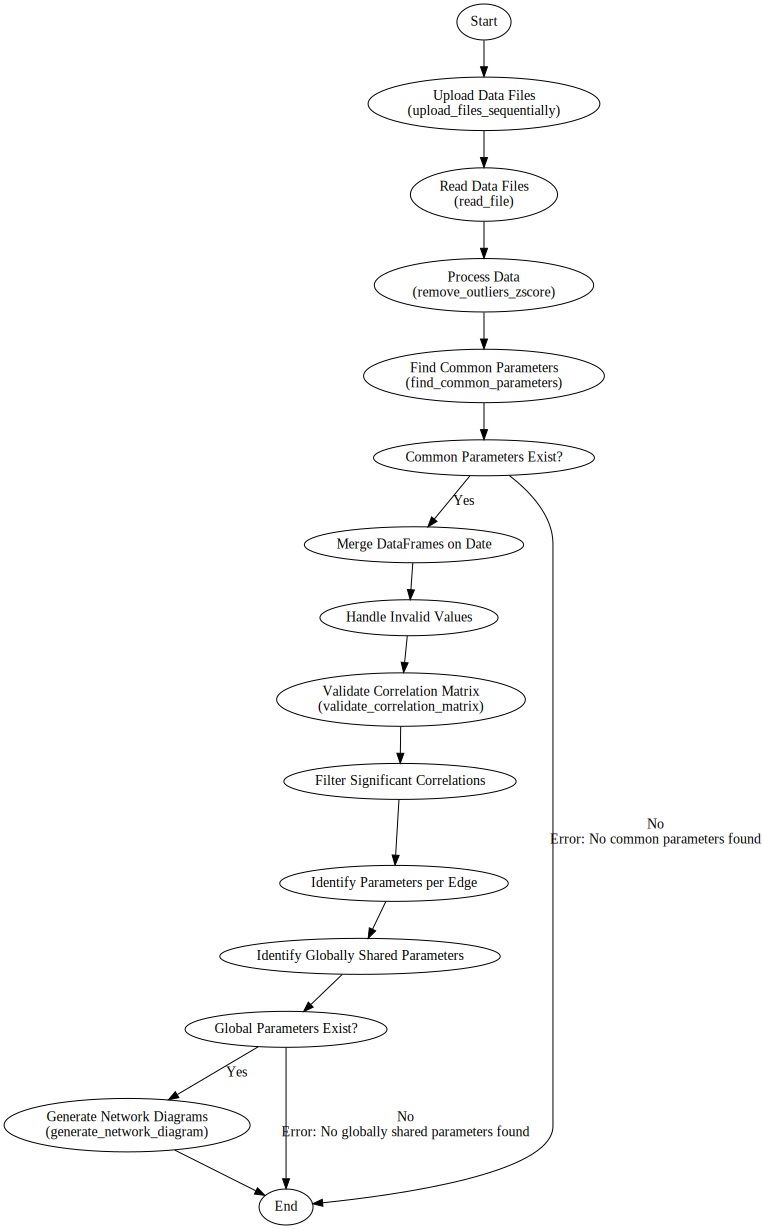

In [ ]:
# Install the graphviz library if not already installed
# !pip install graphviz

from graphviz import Digraph
from IPython.display import display

def generate_cluster1_flowchart():
    dot = Digraph(comment='Cluster 1 Flowchart', format='svg')  # Use SVG format for inline display

    # Nodes
    dot.node('Start', 'Start')
    dot.node('Upload', 'Upload Data Files\n(upload_files_sequentially)')
    dot.node('Read', 'Read Data Files\n(read_file)')
    dot.node('ProcessData', 'Process Data\n(remove_outliers_zscore)')
    dot.node('CommonParams', 'Find Common Parameters\n(find_common_parameters)')
    dot.node('CheckCommon', 'Common Parameters Exist?')
    dot.node('MergeData', 'Merge DataFrames on Date')
    dot.node('HandleValues', 'Handle Invalid Values')
    dot.node('ValidateCorr', 'Validate Correlation Matrix\n(validate_correlation_matrix)')
    dot.node('FilterCorr', 'Filter Significant Correlations')
    dot.node('IdentifyParams', 'Identify Parameters per Edge')
    dot.node('GlobalParams', 'Identify Globally Shared Parameters')
    dot.node('CheckGlobal', 'Global Parameters Exist?')
    dot.node('GenerateDiagrams', 'Generate Network Diagrams\n(generate_network_diagram)')
    dot.node('End', 'End')

    # Edges
    dot.edge('Start', 'Upload')
    dot.edge('Upload', 'Read')
    dot.edge('Read', 'ProcessData')
    dot.edge('ProcessData', 'CommonParams')
    dot.edge('CommonParams', 'CheckCommon')
    dot.edge('CheckCommon', 'MergeData', label='Yes')
    dot.edge('CheckCommon', 'End', label='No\nError: No common parameters found')
    dot.edge('MergeData', 'HandleValues')
    dot.edge('HandleValues', 'ValidateCorr')
    dot.edge('ValidateCorr', 'FilterCorr')
    dot.edge('FilterCorr', 'IdentifyParams')
    dot.edge('IdentifyParams', 'GlobalParams')
    dot.edge('GlobalParams', 'CheckGlobal')
    dot.edge('CheckGlobal', 'GenerateDiagrams', label='Yes')
    dot.edge('CheckGlobal', 'End', label='No\nError: No globally shared parameters found')
    dot.edge('GenerateDiagrams', 'End')

    # Return the dot object
    return dot

# Generate the flowchart
cluster1_flowchart = generate_cluster1_flowchart()

# Display the flowchart inline
display(cluster1_flowchart)


# **Cluster 2 Flowchart**

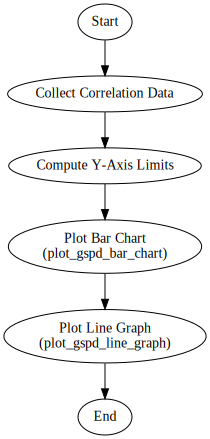

In [ ]:
from graphviz import Digraph
from IPython.display import display

def generate_cluster2_flowchart():
    dot = Digraph(comment='Cluster 2 Flowchart', format='svg')

    # Nodes
    dot.node('Start', 'Start')
    dot.node('CollectData', 'Collect Correlation Data')
    dot.node('ComputeYLimits', 'Compute Y-Axis Limits')
    dot.node('PlotBarChart', 'Plot Bar Chart\n(plot_gspd_bar_chart)')
    dot.node('PlotLineGraph', 'Plot Line Graph\n(plot_gspd_line_graph)')
    dot.node('End', 'End')

    # Edges
    dot.edge('Start', 'CollectData')
    dot.edge('CollectData', 'ComputeYLimits')
    dot.edge('ComputeYLimits', 'PlotBarChart')
    dot.edge('PlotBarChart', 'PlotLineGraph')
    dot.edge('PlotLineGraph', 'End')

    # Return the dot object
    return dot

# Generate the flowchart
cluster2_flowchart = generate_cluster2_flowchart()

# Display the flowchart inline
display(cluster2_flowchart)


# **Cluster 3 Flowchart**

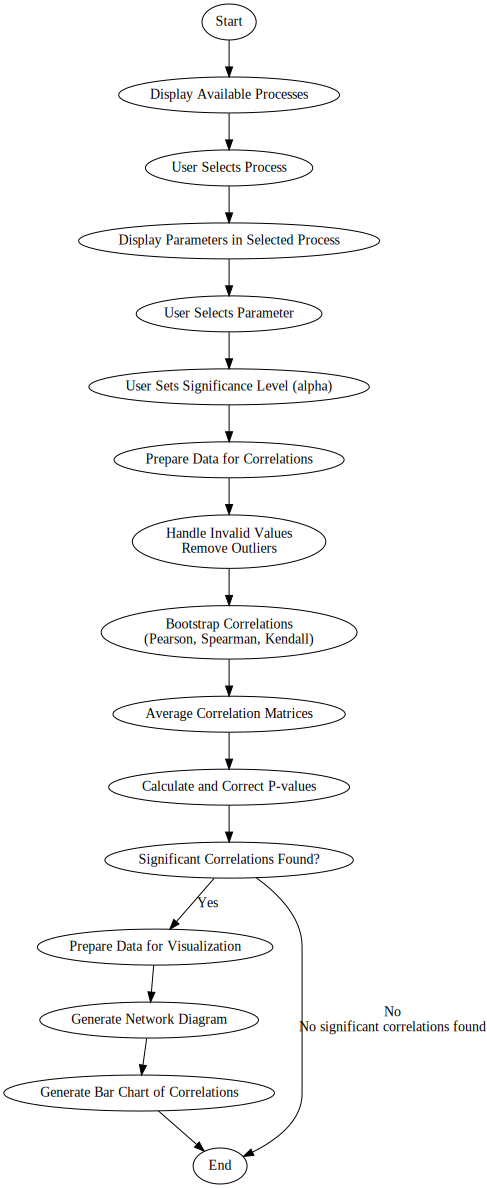

In [ ]:
from graphviz import Digraph
from IPython.display import display

def generate_cluster3_flowchart():
    dot = Digraph(comment='Cluster 3 Flowchart', format='svg')

    # Nodes
    dot.node('Start', 'Start')
    dot.node('DisplayProcesses', 'Display Available Processes')
    dot.node('SelectProcess', 'User Selects Process')
    dot.node('DisplayParameters', 'Display Parameters in Selected Process')
    dot.node('SelectParameter', 'User Selects Parameter')
    dot.node('SetAlpha', 'User Sets Significance Level (alpha)')
    dot.node('PrepareData', 'Prepare Data for Correlations')
    dot.node('HandleValues', 'Handle Invalid Values\nRemove Outliers')
    dot.node('BootstrapCorr', 'Bootstrap Correlations\n(Pearson, Spearman, Kendall)')
    dot.node('AverageCorr', 'Average Correlation Matrices')
    dot.node('CalculatePValues', 'Calculate and Correct P-values')
    dot.node('CheckSignificant', 'Significant Correlations Found?')
    dot.node('PrepareVisualization', 'Prepare Data for Visualization')
    dot.node('GenerateDiagram', 'Generate Network Diagram')
    dot.node('GenerateBarChart', 'Generate Bar Chart of Correlations')
    dot.node('End', 'End')

    # Edges
    dot.edge('Start', 'DisplayProcesses')
    dot.edge('DisplayProcesses', 'SelectProcess')
    dot.edge('SelectProcess', 'DisplayParameters')
    dot.edge('DisplayParameters', 'SelectParameter')
    dot.edge('SelectParameter', 'SetAlpha')
    dot.edge('SetAlpha', 'PrepareData')
    dot.edge('PrepareData', 'HandleValues')
    dot.edge('HandleValues', 'BootstrapCorr')
    dot.edge('BootstrapCorr', 'AverageCorr')
    dot.edge('AverageCorr', 'CalculatePValues')
    dot.edge('CalculatePValues', 'CheckSignificant')
    dot.edge('CheckSignificant', 'PrepareVisualization', label='Yes')
    dot.edge('CheckSignificant', 'End', label='No\nNo significant correlations found')
    dot.edge('PrepareVisualization', 'GenerateDiagram')
    dot.edge('GenerateDiagram', 'GenerateBarChart')
    dot.edge('GenerateBarChart', 'End')

    # Return the dot object
    return dot

# Generate the flowchart
cluster3_flowchart = generate_cluster3_flowchart()

# Display the flowchart inline
display(cluster3_flowchart)
